In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

### Datasets

#### Real (SAheart)

In [3]:
sa_data = pd.read_csv("data/SAheart.data")
sa_data = sa_data.drop("row.names", axis=1)
sa_data["famhist"] = sa_data["famhist"].map({"Present": 1, "Absent": 0})
y_real = sa_data["chd"]
x_real = sa_data.drop("chd", axis=1)

#### Artificial

In [4]:
def generate_data(n, b, k):
    # number of features
    k = k + 5
    beta = np.zeros(k)
    beta[:5] = b
    x = np.random.normal(size=(n, k))
    probability = 1 / (1 + np.exp(-np.dot(beta, x.T)))
    y = np.random.binomial(1, probability)
    return x, y

In [5]:
generate_data(n=5, b=2, k=1)

(array([[-0.91940564, -1.37441172, -0.71666661,  0.97314823, -0.96740876,
         -0.97628119],
        [ 2.75382515,  2.09026018,  1.10956046, -0.6698505 , -0.84764223,
         -0.02057864],
        [ 0.70096929, -0.9860394 , -0.36544379,  1.22626416, -1.03839158,
          0.94009475],
        [ 0.33270587,  0.55816099,  0.85211526,  0.50321102,  0.82892153,
          0.82280362],
        [-1.41010712,  1.32700843, -1.95698809,  1.79664421, -1.40588428,
         -0.53546906]]),
 array([0, 1, 0, 1, 0]))

In [6]:
artificial_x, artificial_y = generate_data(n=1000, b=1, k=20)

### Testing different estimations schemas 

#### Real

##### Refitting

In [7]:
# logistic regression
logistic = LogisticRegression()
logistic.fit(x_real, y_real)
print(
    "Logistic regression accuracy: ",
    accuracy_score(y_real, logistic.predict(x_real)),
)

# decision tree
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(x_real, y_real)
print("Decision tree accuracy: ", accuracy_score(y_real, tree.predict(x_real)))

Logistic regression accuracy:  0.7294372294372294
Decision tree accuracy:  0.7705627705627706


##### Train test split

In [8]:
# splot data
x_train, x_test, y_train, y_test = train_test_split(x_real, y_real, test_size=0.2)


# logistic regression
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
print(
    "Logistic regression accuracy: ",
    accuracy_score(y_test, logistic.predict(x_test)),
)

# decision tree
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(x_train, y_train)
print("Decision tree accuracy: ", accuracy_score(y_test, tree.predict(x_test)))

Logistic regression accuracy:  0.7096774193548387
Decision tree accuracy:  0.6989247311827957


##### 10-fold CV

In [9]:
# cross validation
logistic = LogisticRegression()
tree = DecisionTreeClassifier(max_depth=3)
print(
    "Logistic regression cross validation: ",
    cross_val_score(logistic, x_real, y_real, cv=10).mean(),
)
print(
    "Decision tree cross validation: ",
    cross_val_score(tree, x_real, y_real, cv=10).mean(),
)

Logistic regression cross validation:  0.7100370027752081
Decision tree cross validation:  0.6904255319148936


##### Bootstrap method

In [10]:
def train_test_split_bootstrap_OOB(X, y):
    sample = X.sample(frac=1, replace=True)
    mask = X.index.difference(sample.index)
    return X.loc[sample.index], y.loc[sample.index], X.loc[mask], y.loc[mask]

In [11]:
x, y = generate_data(n=5, b=2, k=1)
x, y = pd.DataFrame(x), pd.Series(y)
train_test_split_bootstrap_OOB(x, y)

(          0         1         2         3         4         5
 4  0.091300  0.521622  1.763793 -0.292283 -1.522561  0.019353
 3  1.026954  0.467329  0.169102 -0.628250 -0.012549  1.207548
 0 -1.439477  0.340720 -0.553916  1.249694  0.240934 -0.880591
 2  0.182573  1.375529  0.195683  0.051278 -1.061408  1.092774
 2  0.182573  1.375529  0.195683  0.051278 -1.061408  1.092774,
 4    1
 3    1
 0    1
 2    0
 2    0
 dtype: int64,
           0         1         2         3         4         5
 1 -0.082529  0.573243  0.245706 -0.954392 -0.787441 -0.179748,
 1    1
 dtype: int64)

In [12]:
def bootstrap_OOB_accuracy(X, y, model):
    accuracies = []
    for _ in range(200):
        x_train, y_train, x_test, y_test = train_test_split_bootstrap_OOB(X, y)
        model.fit(x_train, y_train)
        accuracies.append(accuracy_score(y_test, model.predict(x_test)))
    return np.mean(accuracies)

In [13]:
# bootstrap OOB
logistic = LogisticRegression()
tree = DecisionTreeClassifier(max_depth=3)

print(
    "Logistic regression bootstrap OOB: ",
    bootstrap_OOB_accuracy(x_real, y_real, logistic),
)
print(
    "Decision tree bootstrap OOB: ",
    bootstrap_OOB_accuracy(x_real, y_real, tree),
)

Logistic regression bootstrap OOB:  0.7056188457191195
Decision tree bootstrap OOB:  0.6778830488704748


##### Bootstrap 0.632

In [14]:
def bootstrap_632_accuracy(X, y, model):
    accuracies = []
    for _ in range(200):
        x_train, y_train, x_test, y_test = train_test_split_bootstrap_OOB(X, y)
        model.fit(x_train, y_train)
        accuracies.append(
            0.632 * accuracy_score(y_test, model.predict(x_test))
            + 0.368 * accuracy_score(y_train, model.predict(x_train))
        )
    return np.mean(accuracies)

In [15]:
# bootstrap .632
logistic = LogisticRegression()
tree = DecisionTreeClassifier(max_depth=3)

print(
    "Logistic regression bootstrap .632: ",
    bootstrap_632_accuracy(x_real, y_real, logistic),
)
print(
    "Decision tree bootstrap .632: ",
    bootstrap_632_accuracy(x_real, y_real, tree),
)

Logistic regression bootstrap .632:  0.7192666737547352
Decision tree bootstrap .632:  0.7108869473175031


#### Artificial

##### Refitting

In [16]:
# logistic regression
logistic = LogisticRegression()
logistic.fit(artificial_x, artificial_y)
print(
    "Logistic regression accuracy: ",
    accuracy_score(artificial_y, logistic.predict(artificial_x)),
)

# decision tree
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(artificial_x, artificial_y)
print(
    "Decision tree accuracy: ", accuracy_score(artificial_y, tree.predict(artificial_x))
)

Logistic regression accuracy:  0.831
Decision tree accuracy:  0.732


##### Train test split

In [17]:
# splot data
x_train, x_test, y_train, y_test = train_test_split(
    artificial_x, artificial_y, test_size=0.2
)


# logistic regression
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
print(
    "Logistic regression accuracy: ",
    accuracy_score(y_test, logistic.predict(x_test)),
)

# decision tree
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(x_train, y_train)
print("Decision tree accuracy: ", accuracy_score(y_test, tree.predict(x_test)))

Logistic regression accuracy:  0.81
Decision tree accuracy:  0.64


##### 10-fold CV

In [18]:
# cross validation
logistic = LogisticRegression()
tree = DecisionTreeClassifier(max_depth=3)
print(
    "Logistic regression cross validation: ",
    cross_val_score(logistic, artificial_x, artificial_y, cv=10).mean(),
)
print(
    "Decision tree cross validation: ",
    cross_val_score(tree, artificial_x, artificial_y, cv=10).mean(),
)

Logistic regression cross validation:  0.821
Decision tree cross validation:  0.7


##### Bootstrap method

In [19]:
# bootstrap OOB
artificial_x, artificial_y = pd.DataFrame(artificial_x), pd.Series(artificial_y)
logistic = LogisticRegression()
tree = DecisionTreeClassifier(max_depth=3)

print(
    "Logistic regression bootstrap OOB: ",
    bootstrap_OOB_accuracy(artificial_x, artificial_y, logistic),
)
print(
    "Decision tree bootstrap OOB: ",
    bootstrap_OOB_accuracy(artificial_x, artificial_y, tree),
)

Logistic regression bootstrap OOB:  0.8095862013884347
Decision tree bootstrap OOB:  0.6788215853843568


##### Bootstrap 0.632

In [20]:
# bootstrap .632
logistic = LogisticRegression()
tree = DecisionTreeClassifier(max_depth=3)

print(
    "Logistic regression bootstrap .632: ",
    bootstrap_632_accuracy(x_real, y_real, logistic),
)
print(
    "Decision tree bootstrap .632: ",
    bootstrap_632_accuracy(x_real, y_real, tree),
)

Logistic regression bootstrap .632:  0.7198935296658473
Decision tree bootstrap .632:  0.711404001564401


### ROC and precision-recall curves

Text(0.5, 1.0, 'ROC curve')

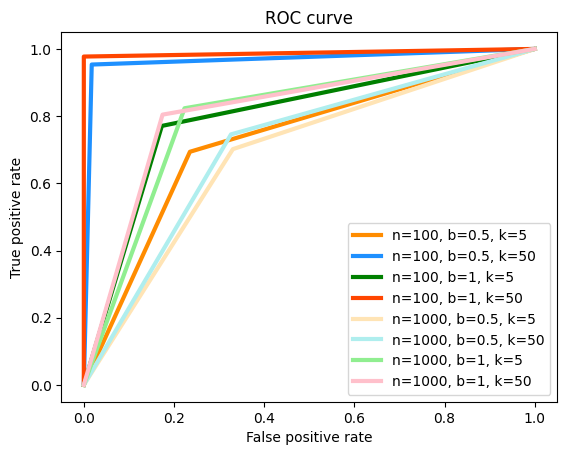

In [32]:
from sklearn.metrics import roc_curve

n = [100, 1000]
b = [0.5, 1]
k = [5, 50]
colors = [
    "pink",
    "lightgreen",
    "paleturquoise",
    "moccasin",
    "orangered",
    "green",
    "dodgerblue",
    "darkorange",
]
for i in n:
    for j in b:
        for l in k:
            artificial_x, artificial_y = generate_data(n=i, b=j, k=l)
            artificial_x, artificial_y = pd.DataFrame(artificial_x), pd.Series(
                artificial_y
            )
            logistic = LogisticRegression()
            logistic.fit(artificial_x, artificial_y)
            fpr, tpr, _ = roc_curve(artificial_y, logistic.predict(artificial_x))
            plt.plot(
                fpr, tpr, label=f"n={i}, b={j}, k={l}", color=colors.pop(), linewidth=3
            )
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")

Text(0.5, 1.0, 'Precision-recall curve')

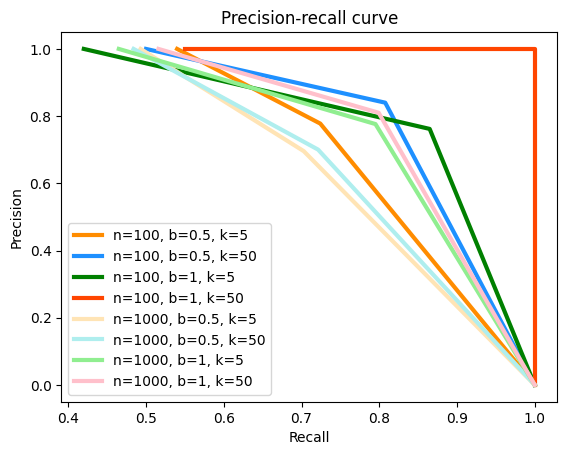

In [33]:
from sklearn.metrics import precision_recall_curve

n = [100, 1000]
b = [0.5, 1]
k = [5, 50]
colors = [
    "pink",
    "lightgreen",
    "paleturquoise",
    "moccasin",
    "orangered",
    "green",
    "dodgerblue",
    "darkorange",
]
for i in n:
    for j in b:
        for l in k:
            artificial_x, artificial_y = generate_data(n=i, b=j, k=l)
            artificial_x, artificial_y = pd.DataFrame(artificial_x), pd.Series(
                artificial_y
            )
            logistic = LogisticRegression()
            logistic.fit(artificial_x, artificial_y)
            fpr, tpr, _ = precision_recall_curve(
                artificial_y, logistic.predict(artificial_x)
            )
            plt.plot(
                fpr, tpr, label=f"n={i}, b={j}, k={l}", color=colors.pop(), linewidth=3
            )
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-recall curve")

Red curve is a result of overfitting 